# Week 1 Submission for NBA career modelling

## Load Required Packages 

In [179]:
import os
import pandas as pd #data manipulation
import numpy as np
import sklearn # models
import seaborn as sns # visualisation
import matplotlib.pyplot as plt # visualisation
import xgboost as xgb
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
%matplotlib inline 
# visualisation inline in notebook

## Import Data 

In [169]:
## Import Data 
data_path = '/Users/james/projects/adsi/group1_nba_career_prediction/data/raw'
train_data = data_path + '/train.csv'
test_data = data_path + '/test.csv'
df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)
df_test

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,-0.0,1.8
2,3,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,8175,84,21.2,8.7,3.4,6.7,50.2,0.0,-0.0,-4.5,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,8176,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,8178,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,8181,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,24.7,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [170]:
## Set index for df_train
df_train = df_train.set_index('Id')

## Conduct EDA

In [171]:
## Check the type and quality of the data
df_train.info()
## Check the basic description of the data
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 10556 to 2900
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GP           8000 non-null   int64  
 1   MIN          8000 non-null   float64
 2   PTS          8000 non-null   float64
 3   FGM          8000 non-null   float64
 4   FGA          8000 non-null   float64
 5   FG%          8000 non-null   float64
 6   3P Made      8000 non-null   float64
 7   3PA          8000 non-null   float64
 8   3P%          8000 non-null   float64
 9   FTM          8000 non-null   float64
 10  FTA          8000 non-null   float64
 11  FT%          8000 non-null   float64
 12  OREB         8000 non-null   float64
 13  DREB         8000 non-null   float64
 14  REB          8000 non-null   float64
 15  AST          8000 non-null   float64
 16  STL          8000 non-null   float64
 17  BLK          8000 non-null   float64
 18  TOV          8000 non-null   float64
 19  TA

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,19.583700,1.392525,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,0.926153,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,0.000000,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [172]:
df_train[df_train < 0] = 0
df_train

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id,,,,,,,,,,,,,,,,,,,,
10556,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
5342,75,21.8,10.5,4.2,7.9,55.1,0.0,0.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
5716,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
13790,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
5470,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,32,9.2,1.8,0.7,1.8,40.3,0.0,0.0,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
11679,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
5537,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1


In [173]:
df_train.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,62.779250,18.576662,7.267088,2.807037,6.231212,44.608900,0.319238,0.948675,20.393713,1.392525,1.947788,71.367488,1.077838,2.168500,3.245300,1.624513,0.648687,0.314050,1.257763,0.833625
std,17.113463,8.935263,4.318732,1.693373,3.584559,6.155453,0.307238,0.870167,14.602879,0.926153,1.252352,10.418003,0.785670,1.392224,2.085154,1.355986,0.407626,0.622078,0.723270,0.372440
min,0.000000,2.900000,0.800000,0.300000,0.800000,21.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


<AxesSubplot:>

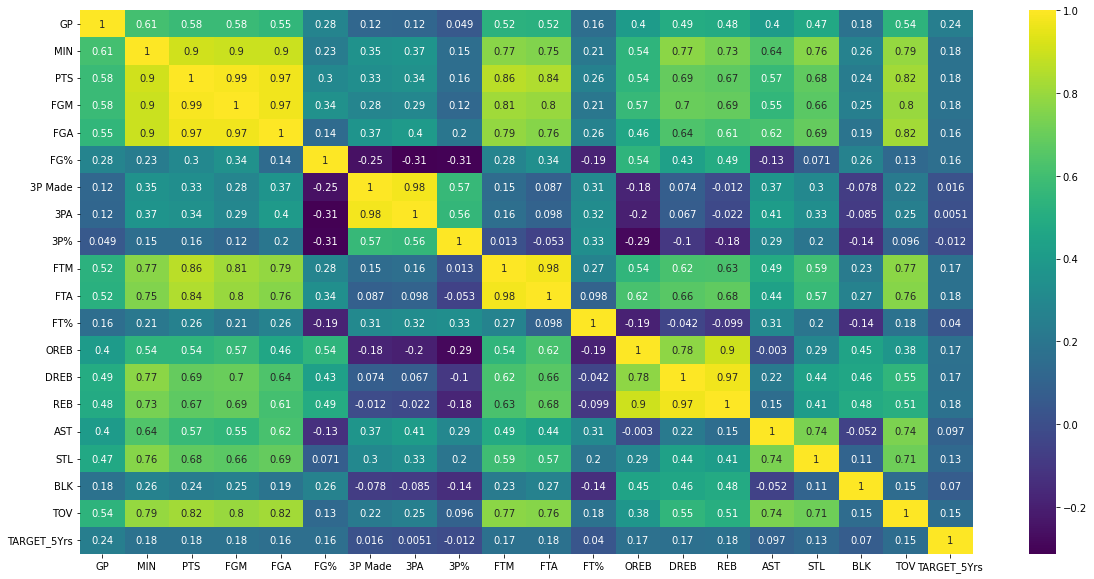

In [137]:
## Check for correlation between values to inform parameter selection for modelling
plt.figure(figsize=(20,10))
sns.heatmap(df_train.corr(),cmap='viridis',annot=True)

<AxesSubplot:xlabel='TARGET_5Yrs'>

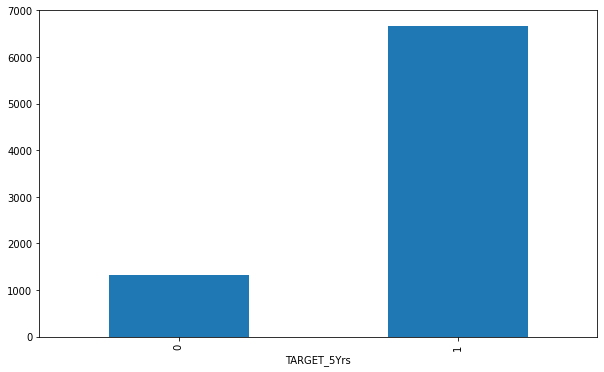

In [138]:
GroupedData=df_train.groupby('TARGET_5Yrs').size()
GroupedData.plot(kind='bar', figsize=(10,6))

There appears to be an imbalanced data set between the classes in the target variable. In order to reduce the effects of the model a weight will have to be applied to this to balance out the differences. Oversampling will be performed using SMOTE. 

In [139]:
## Split the Data into a test/ train set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)
X_train

array([[84. , 24.7,  7.2, ...,  1. ,  0.1,  1.9],
       [71. , 19.6,  7.8, ...,  1.4,  0.3,  2.4],
       [45. , 11.7,  3.2, ...,  0.8,  0.2,  0.7],
       ...,
       [72. , 18.6,  9.8, ...,  0.8,  0.2,  1.5],
       [69. , 22. , 11.2, ...,  0.4,  0.6,  1.6],
       [71. , 15.2,  6.7, ...,  0.6,  0.1,  1.6]])

In [140]:
## Impletement a SMOTE 
print('Before oversamplining:', Counter(y_train))

Before oversamplining: Counter({1: 4802, 0: 958})


In [141]:
# define oversampling strategy
SMOTE = SMOTE()
SMOTE

SMOTE()

In [142]:
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)


In [143]:
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({1: 4802, 0: 4802})


## Build an initial model

In [144]:
## Separate the target variable from the rest of the variables
TargetVariable = df_train['TARGET_5Yrs']
print(TargetVariable)
Predictors = df_train.loc[:, ['GP', 'MIN', 'PTS', 'FTM', 'FG%', '3P%', 'FT%', 'REB', 'STL']]
print(Predictors)
X = Predictors.values
y = TargetVariable.values
print(X)
print(y)

Id
10556    1
5342     1
5716     1
13790    1
5470     1
        ..
2996     1
11679    1
5537     1
1292     1
2900     1
Name: TARGET_5Yrs, Length: 8000, dtype: int64
       GP   MIN   PTS  FTM   FG%   3P%   FT%  REB  STL  BLK  TOV
Id                                                              
10556  80  24.3   7.8  2.0  45.7  22.6  72.1  3.8  1.1  0.2  1.6
5342   75  21.8  10.5  2.4  55.1  34.9  67.8  6.6  0.5  0.6  1.4
5716   85  19.1   4.5  0.4  42.8  34.3  75.7  2.4  0.4  0.2  0.6
13790  63  19.1   8.2  0.9  52.5  23.7  66.9  3.0  0.4  0.1  1.9
5470   63  17.8   3.7  0.2  50.8  13.7  54.0  4.9  0.4  0.6  0.7
...    ..   ...   ...  ...   ...   ...   ...  ...  ...  ...  ...
2996   32   9.2   1.8  0.4  40.3  23.1  65.7  1.9  0.3  0.2  0.4
11679  54   6.0   1.8  0.2  48.7   3.1  70.1  2.0  0.0  0.3  0.3
5537   85  28.2  10.7  2.8  45.1  23.6  69.7  3.1  1.2  0.2  1.8
1292   39   7.7   2.5  0.6  40.1  13.3  74.3  0.9  0.3  0.3  0.5
2900   49  19.2   4.8  0.8  32.6  41.3  70.1  1.2 

In [182]:
## Build the model
from xgboost import XGBClassifier

clf=XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=1000, objective='binary:logistic', booster='gbtree')
print(clf)

XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)


In [183]:
## Create a model on the train data

XGB=clf.fit(X_train, y_train)
XGB

## prediction on test data
prediction = XGB.predict(X_test)
prediction

/Users/james/projects/adsi/adsi/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1, 1, 1, ..., 1, 1, 1])

In [184]:
XGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [185]:
## Measure accuracy of prediction
log_model = LogisticRegression()
log_model.fit(X_train,y_train)
pred_log = log_model.predict(X_test)

print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.28      0.09      0.14       373
           1       0.84      0.95      0.89      1867

    accuracy                           0.81      2240
   macro avg       0.56      0.52      0.52      2240
weighted avg       0.75      0.81      0.77      2240



/Users/james/projects/adsi/adsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 15.0, 'Predicted label')

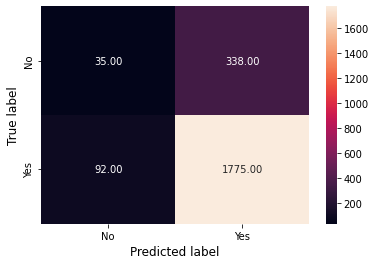

In [186]:
cm = metrics.confusion_matrix(y_test, prediction)

sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)

In [175]:
metrics.accuracy_score(y_test,pred_log)

NameError: name 'pred_log' is not defined

In [149]:
Predictors.reset_index(drop=True)

,GP,MIN,PTS,FTM,FG%,3P%,FT%,REB,STL,BLK,TOV
0,80,24.3,7.8,2.0,45.7,22.6,72.1,3.8,1.1,0.2,1.6
1,75,21.8,10.5,2.4,55.1,34.9,67.8,6.6,0.5,0.6,1.4
2,85,19.1,4.5,0.4,42.8,34.3,75.7,2.4,0.4,0.2,0.6
3,63,19.1,8.2,0.9,52.5,23.7,66.9,3.0,0.4,0.1,1.9
4,63,17.8,3.7,0.2,50.8,13.7,54.0,4.9,0.4,0.6,0.7
...,...,...,...,...,...,...,...,...,...,...,...
7995,32,9.2,1.8,0.4,40.3,23.1,65.7,1.9,0.3,0.2,0.4
7996,54,6.0,1.8,0.2,48.7,3.1,70.1,2.0,0.0,0.3,0.3
7997,85,28.2,10.7,2.8,45.1,23.6,69.7,3.1,1.2,0.2,1.8
7998,39,7.7,2.5,0.6,40.1,13.3,74.3,0.9,0.3,0.3,0.5


<BarContainer object of 11 artists>

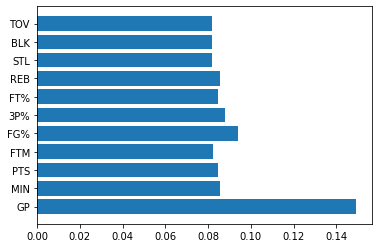

In [150]:
## Plot feature importance 
XGB.feature_importances_
plt.barh(Predictors.reset_index(drop=True).columns, XGB.feature_importances_)

In [151]:
X_test
Predictors = Predictors.reset_index(drop=True)
Predictors.columns

Index(['GP', 'MIN', 'PTS', 'FTM', 'FG%', '3P%', 'FT%', 'REB', 'STL', 'BLK',
       'TOV'],
      dtype='object')

In [152]:
results = pd.DataFrame(data = X_test, columns = Predictors.columns)
results['Target'] = y_test
results['Prediction'] = prediction
results['Target'].unique()

array([1, 0])

In [153]:
## Load and pre-process test data

df_test[df_test < 0] = 0
df_test

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,-0.0,1.8
2,3,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,0.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,8175,84,21.2,8.7,3.4,6.7,50.2,0.0,-0.0,0.0,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,8176,49,16.3,6.4,2.9,6.6,44.4,0.0,0.0,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,8178,53,9.9,2.1,0.8,1.8,43.1,0.0,0.0,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,8181,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,24.7,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [154]:
## Load test data 
pred_cols = Predictors.columns
pred_cols
df_test_pred = df_test[pred_cols]
df_test_pred

,GP,MIN,PTS,FTM,FG%,3P%,FT%,REB,STL,BLK,TOV
0,56,9.1,4.0,0.7,43.7,7.3,63.4,1.7,0.2,0.3,0.8
1,43,19.3,10.1,1.8,46.0,35.1,75.3,1.5,0.6,-0.0,1.8
2,82,33.9,11.3,1.8,45.6,44.8,71.2,4.5,1.3,0.3,2.0
3,86,44.7,18.8,4.5,42.9,13.5,70.9,5.0,0.9,0.1,3.6
4,58,12.3,4.7,1.1,40.0,38.7,76.9,0.9,0.5,0.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...
3794,84,21.2,8.7,1.7,50.2,0.0,68.1,3.9,0.6,0.3,2.0
3795,49,16.3,6.4,1.0,44.4,19.8,50.2,4.4,0.4,0.4,0.7
3796,53,9.9,2.1,0.6,43.1,1.9,63.9,1.7,0.4,0.2,0.5
3797,89,38.3,14.5,2.5,45.2,24.7,89.2,5.5,1.3,0.3,2.4


In [155]:
test_pred = pd.DataFrame(XGB.predict_proba(df_test_pred))
test_pred_df = pd.DataFrame(test_pred[1])
test_pred_df.columns = ['TARGET_5Yrs']
test_pred_df

/Users/james/projects/adsi/adsi/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,TARGET_5Yrs
0,0.823006
1,0.823028
2,0.998831
3,0.999095
4,0.791009
...,...
3794,0.993472
3795,0.909934
3796,0.946976
3797,0.973174


In [156]:
Id = pd.DataFrame(df_test['Id'])
Id

,Id
0,1
1,8194
2,3
3,8196
4,8197
...,...
3794,8175
3795,8176
3796,8178
3797,8181


In [157]:
submission = Id.join(test_pred_df)
submission.to_csv('/Users/james/projects/adsi/group1_nba_career_prediction/models/model_4.csv', index = False)